In [17]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd

from config import Config
from img_util import show_img_tensor_CHW
from fliker_img_comment_dataset import ImgCommentDataset
from pathlib import Path
import torch
from torch.utils.data import DataLoader


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
img_comments_folder = Path("/Users/chengbai/ml/dataset/flickr30k_images/")
img_comments_file = img_comments_folder / "results.csv" # /Users/chengbai/ml/dataset/flickr30k_images/results.csv
imgs_folder = img_comments_folder / "flickr30k_images"  # /Users/chengbai/ml/dataset/flickr30k_images/flickr30k_images

list(imgs_folder.glob("*.jpg"))[:2]

[PosixPath('/Users/chengbai/ml/dataset/flickr30k_images/flickr30k_images/2609797461.jpg'),
 PosixPath('/Users/chengbai/ml/dataset/flickr30k_images/flickr30k_images/1788892671.jpg')]

In [19]:
# The current `results.csv` file is using "| " to seperate 3 columns. 
# For the pd.read_csv, the `sep` here is given as a regular expression. 
df = pd.read_csv(img_comments_file, sep="|", index_col=False)
df = df.astype({'image_name': 'str', 'comment_number': int, 'comment': str})
df1 = df[0: 1]
list(df1["image_name"]), df1["image_name"][0]


(['1000092795.jpg'], '1000092795.jpg')

In [20]:
config = Config()
train_dataset = ImgCommentDataset(config, img_comments_folder, train_test_split="train", train_test_split_portion=0.8)
test_dataset = ImgCommentDataset(config, img_comments_folder, train_test_split="test", train_test_split_portion=0.8)
print(len(train_dataset), len(test_dataset))

Enriched img id: /tmp/enriched_results.csv
Enriched img id: /tmp/enriched_results.csv
127132 31783


idx: 0


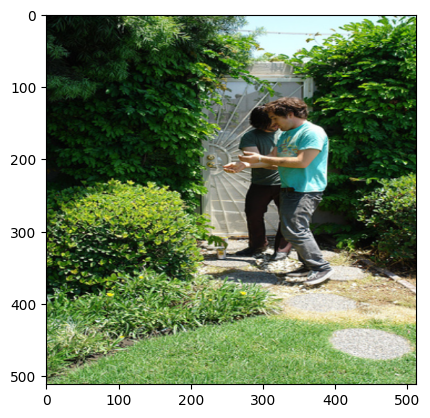

In [21]:
img_tensor, img_id_tensor, comment_encoding = train_dataset[0]
show_img_tensor_CHW(img_tensor)

In [22]:
# Data Loader
BATCH_SIZE = 2
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [23]:
# for batch_data in train_dataloader:
#     print(train_dataloader)
#     break
batch_img_tensors, batch_img_id_tensors, batch_text_encodings = next(iter(train_dataloader))
print(f"batch_img_tensors: {batch_img_tensors.size()}")
print(f"batch_img_id_tensors: {batch_img_id_tensors.size()}")
print(f"batch_text_encodings: {batch_text_encodings.size()}")

idx: 12021
idx: 105566
batch_img_tensors: torch.Size([2, 3, 512, 512])
batch_img_id_tensors: torch.Size([2])
batch_text_encodings: torch.Size([2, 50])


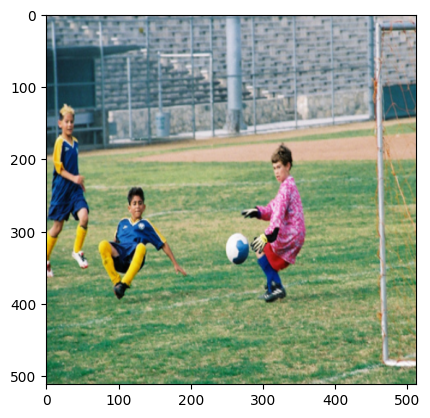

In [24]:
plt.imshow(batch_img_tensors[0].permute(1, 2, 0)) # C x H x W => H x W x C